In [4]:
#set the base path of the EW_Model folder
base_path = r'C:\Users\matteobb\OneDrive - Princeton University\Codes'

In [5]:
import os
import time; start_time = time.time()
import importlib as imp
import pyEW
import pyeto as eto
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import warnings
import pandas as pd
import json
# Set Arial as the default font family
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})

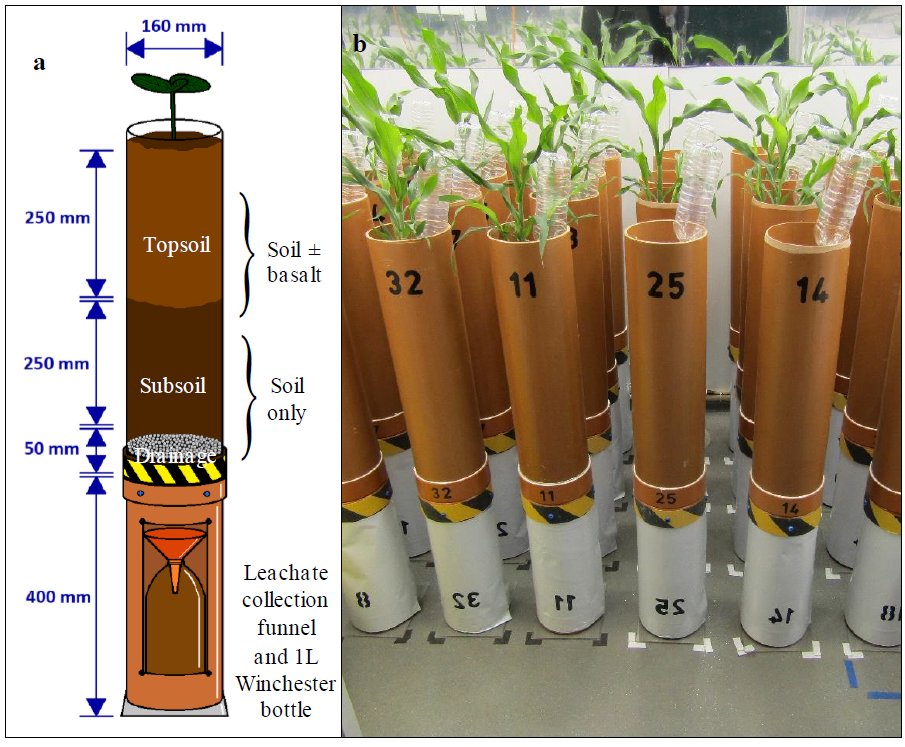

In [6]:
# time 
t_end = 121 # [d]: number of simulated days
dt = 1/(24*6) # [time resolution (d)]
t=np.arange(0,t_end,dt)

#units
conv_mol = 1e6 # Conversion from moles to micromols 
conv_Al = 1e3 # Conversion for Al species from mols to nanomols

#water balance
keyword_wb = 1 # 1 = varying soil moisture. 0 = constant soil moisture

#background inputs of cations and anions
keyword_add = 0 # 1 = balance background losses. 0 = no addition

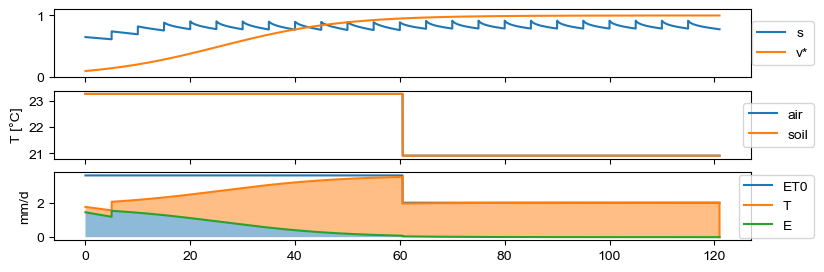

In [7]:
# HYDROCLIMATE AND WATER BALANCE

#soil 
soil = "clay loam" #sand, loamy sand, sandy loam, loam
Zr = 0.5 # [m]: soil depth
A_column = np.pi*(0.16/2)**2 # [m2]
m_column = 1e3*9.3 #[g]
rho_bulk = m_column/(A_column*Zr) #soil dry mass (g/m3)

#hydroclimatic
wind = 0.5*np.ones(len(t)) #[m/s]
temp_day = 25 #[°C]
temp_night = 18 #[°C]
t_light = np.array([18/24, 10/24]) #[d]
net_rad = 800 # [micromol/m2 s]
net_rad = net_rad/4.6*1e-6*3600*24*t_light # [MJ/ m2 d]

temp_air = np.zeros(len(t))
ET0 = np.zeros(len(t))

j = 0
for i in range(0, len(ET0)):
        temp_air[i] = temp_day*t_light[j] + temp_night*(1-t_light[j]) #[°C]  
        svp = eto.svp_from_t(temp_air[i]) # saturation vapor pressure [kPa]
        avp = eto.avp_from_rhmin_rhmax(eto.svp_from_t(temp_day),eto.svp_from_t(temp_night),60,70) # actual vapor pressure [kPa]
        delta_svp = eto.delta_svp(temp_air[i]) # Slope of saturation vapour pressure curve [kPa C-1]
        psy = eto.psy_const(101.3) #psychrometric constant [kPa degC-1]
        ET0[i] = eto.fao56_penman_monteith(net_rad[j], temp_air[i]+273.15, wind[i], svp, avp, delta_svp, psy, 0) #[mm d-1]
        if i > int(len(ET0)/2):
            j = 1
ET0 = ET0 / 1000 # [m/d]
temp_soil = temp_air #[°C]

#CROP
T_v = 70 # [d] growth time
k_v = 50/A_column # [g/m2] carrying capacity (1 plant mass/ area of the column)
RAI = 10 #[m2/m2] root area index
root_d = 0.4*1e-3 #[m] average root diameter
v_in = 0.1*k_v # [g/m2] ic
t0_v = 0 # [d] starting day of growth
v = pyEW.veg(v_in, T_v, k_v, t0_v, temp_soil, dt)

#moisture balance [m]
s_in = 0.65
rain_tot = 13.9*1e-3/A_column # [m]: total rain during the 120-day exp 
t_rain = np.arange(5,120,5)/dt  #[d]: rain events
t_rain = [int(num) for num in t_rain]
rain = np.zeros(len(t))
rain[t_rain] = rain_tot/len(t_rain)
[s, s_w, s_fc, I, L, T, E, Q, Irr, n] = pyEW.moisture_balance(rain, Zr, soil, ET0, v, k_v, keyword_wb, s_in,t_end,dt)

# Figure
fig, axs = plt.subplots(3, 1,figsize=(9, 3))

axs[0].plot(t,s, label = 's')
axs[0].plot(t, v/k_v, label = 'v*')
axs[0].set_xticklabels([])
axs[0].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
axs[0].set_ylim(0,1.1)

axs[1].plot(t,temp_air,label='air')
axs[1].plot(t,temp_soil,label='soil')
axs[1].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
axs[1].set_ylabel('T [°C]')
axs[1].set_xticklabels([])

axs[2].plot(t,1000*ET0, label ='ET0')
axs[2].plot(t,(E+T)*1000, label ='T')
axs[2].plot(t,E*1000, label ='E')
axs[2].set_ylabel('mm/d')
axs[2].fill_between(t,E*1000, 0,alpha=0.5)
axs[2].fill_between(t,(E+T)*1000,E*1000,alpha=0.5)
axs[2].set_ylabel('mm/d')
axs[2].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

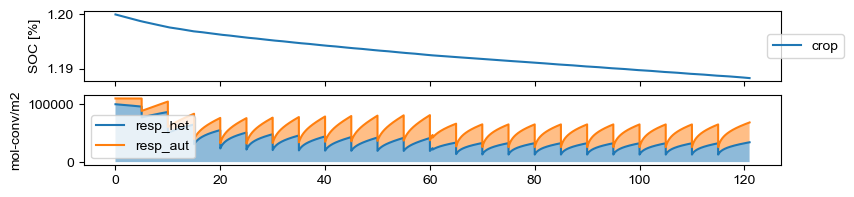

In [8]:
# ORGANIC CARBON and RESPIRATION

#initial pCO2
CO2_air_in = 60*pyEW.CO2_atm(conv_mol) # CO2 in soil air [mol-conv/l] 
ratio_aut_het = 1

#Initial organic carbon
ADD = 0 # added dry litter [gOC/(m2*d)]
SOC_in = rho_bulk*1.2/100 #[gOC/m3] 

#SOC balance and respiration
[SOC, r_het, r_aut, D] = pyEW.respiration(ADD, SOC_in, CO2_air_in, ratio_aut_het, soil, s, v, k_v, Zr, temp_soil,dt,conv_mol)

# figure
fig, axs = plt.subplots(2, 1,figsize=(9, 2))

axs[0].plot(t,100*SOC/(rho_bulk),label='crop')
axs[0].set_xticklabels([])
axs[0].set_xticklabels([])
axs[0].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
axs[0].set_ylabel('SOC [%]')

axs[1].plot(t, r_het, label = 'resp_het')
axs[1].plot(t, r_het + r_aut, label = 'resp_aut')
axs[1].fill_between(t,r_het, 0,alpha=0.5)
axs[1].fill_between(t,r_het + r_aut, r_het,alpha=0.5)
axs[1].legend()
axs[1].set_ylabel('mol-conv/m2')

plt.show()

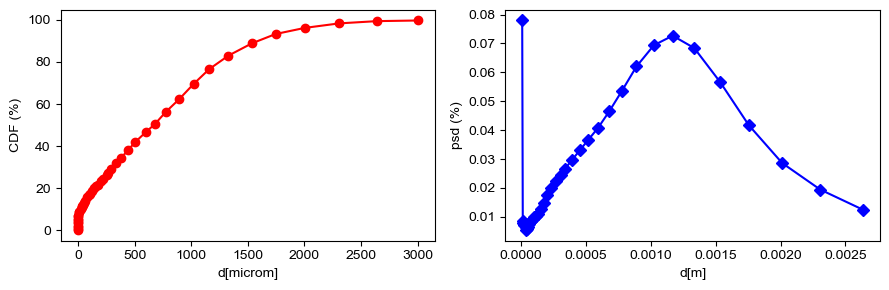

In [9]:
#particle size distribution 
file_path = os.path.join(base_path, 'EW_Model', 'Exp_Data', 'Kelland_2020', 'psd.json')
with open(file_path, 'r') as json_file:
    data_exp_psd = json.load(json_file)
    data_exp_psd = data_exp_psd['datasetColl'][0]['data']
    
file_path = os.path.join(base_path, 'EW_Model', 'Exp_Data', 'Kelland_2020', 'psd_CDF.json')
with open(file_path, 'r') as json_file:
    data_exp_psd_CDF = json.load(json_file)
    data_exp_psd_CDF = data_exp_psd_CDF['datasetColl'][0]['data']
    
#CDF
d_in_CDF = [point['value'][0] for point in data_exp_psd_CDF]
psd_CDF_in = [point['value'][1] for point in data_exp_psd_CDF]

#psd 
d_in_psd = [point['value'][0] for point in data_exp_psd]
psd_in = [point['value'][1] for point in data_exp_psd]    

#reversing (because of how the data have been saved)
d_in_psd = d_in_psd[::-1]
psd_in = psd_in[::-1]

#removing the first 10 numbers (d~0)
d_in_psd=d_in_psd[10:-1]
psd_in = psd_in[10:-1]

#creating a class for d = 10 microm
d_in_psd = np.insert(d_in_psd,0,10)
psd_in = np.insert(psd_in,0,100-np.sum(psd_in)) 

#converting to right units
d_in_psd = d_in_psd*1e-6 #[m]
psd_in = psd_in/100

#figure
fig, axs = plt.subplots(1,2,figsize=(9, 3))
axs[0].plot(d_in_CDF, psd_CDF_in, marker='o', color='red')
axs[0].set_xlabel('d[microm]')
axs[0].set_ylabel('CDF (%)')

axs[1].plot(d_in_psd, psd_in, marker='D', color='blue')
axs[1].set_xlabel('d[m]')
axs[1].set_ylabel('psd (%)')

plt.tight_layout()
plt.show()

In [10]:
# SOIL BIOGEOCHEMISTRY

#initial pH
pH_in = 6.6

#CEC 
CEC_tot = 25.4 # [mmol_c / 100 g dry-soil] 
CEC_tot = CEC_tot*1e-5*rho_bulk*Zr*conv_mol # [mol_c] 

#conc in leachate from untreated experiment (see Table S5)
Ca_in = 800 # [micromol/l]
Mg_in = 70
K_in = 30
Na_in = 190
Si_in = 200 
Al_w_in = 2500 # [nanomol/l]
conc_in = [Ca_in, Mg_in, K_in, Na_in, Al_w_in]
  
#estimated CEC fractions
[f_CEC_in, K_CEC] = pyEW.conc_to_f_CEC(conc_in,pH_in,soil,conv_mol,conv_Al)
if abs(sum(f_CEC_in)-1) > 1e-3:
    raise ValueError("Sum of fractions must be 1")

#carbonates
MgCO3_in = 0
CaCO3_in = 0

#EW application
M_rock_in = 10000 # [g/m2] of added rock powder
mineral = ["labradorite", "alkali_feldspar", "diopside", "Fe_forsterite"]
rock_f_in = np.array([0.35, 0.23, 0.1, 0.01]) # mineral fractions
d_in = np.array(d_in_psd) # [m]: diameter classes
psd_perc_in = np.array(psd_in) # d-class fraction of total mass
SSA_in = 7.35 # [m2/g]: measured ssa
diss_f = 1 #dissolution factor
data = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

#Control application
M_rock_in = 0 # [g/m2] of added rock powder
data_untr = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

C:\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [13]:
#--------------------------------------------------------------------
#ELEMENTAL RELEASES
#--------------------------------------------------------------------

min_st = data['min_st']
EW = data['EW']

# numerical elemental release
Ca_rel = np.dot(min_st[:, 0], EW) # [mol-conv/ m2 d]
Mg_rel = np.dot(min_st[:, 1], EW)
K_rel = np.dot(min_st[:, 2], EW)
Na_rel = np.dot(min_st[:, 3], EW)
Si_rel = np.dot(min_st[:, 5], EW)

#Ca released by apatite (not numerically modeled)
M_apa = 0.03*10000 # [g/m2]
MM_apa = 422/conv_mol # [g/mol-conv]
Ca_rel_apa = M_apa/MM_apa/t_end # [mol-conv/ m2 d]

# numerical averages and std [mmol/m2 d]
num_avg_rel = np.array([np.mean(Ca_rel), np.mean(Ca_rel)+Ca_rel_apa, np.mean(Mg_rel), np.mean(K_rel), np.mean(Na_rel), np.mean(Si_rel)])*1e-3 # [mmol/ m2 d]
num_std_rel = np.array([np.std(Ca_rel), np.std(Ca_rel), np.std(Mg_rel), np.std(K_rel), np.std(Na_rel), np.std(Si_rel)])*1e-3

# experimental elemental release [mmol/m2 d]
exp_avg_rel = np.array([18, 18, 4.2, 1.1, 0.33, 1.9]) 
exp_err_rel = np.array([14, 14, 0.93, 1.4, 0.53, 0.4])

In [14]:
#--------------------------------------------------------------------
# CO2 SEQUESTRATION 
#--------------------------------------------------------------------

#EXPERIMENTS

#potential
CO2_pot_exp = 1e-3*44*(2*(exp_avg_rel[1]+exp_avg_rel[2])+(exp_avg_rel[3]+exp_avg_rel[4])) #[gCO2/m2d]
CO2_pot_exp_std = 1e-3*44*(2*(exp_err_rel[1]+exp_err_rel[2])+(exp_err_rel[3]+exp_err_rel[4])) 

#effective (leaching)
Alk_L_exp = [-31, -0.35, 30, -0.62] # [micromol/m2 d]
Alk_L_std_exp = [91, 5, 17, 11] 
CO2_eff_exp_L = 44*(2*(Alk_L_exp[0]+Alk_L_exp[1])+(Alk_L_exp[2]+Alk_L_exp[3]))/conv_mol #[gCO2/m2d]
CO2_eff_exp_L_std = 44*(2*(Alk_L_std_exp[0]+Alk_L_std_exp[1])+(Alk_L_std_exp[2]+Alk_L_std_exp[3]))/conv_mol 
CO2_eff_exp = CO2_eff_exp_L
CO2_eff_exp_std = CO2_eff_exp_L_std

#NUMERICAL

#potential
CO2_pot_num = 1e-3*44*(2*(num_avg_rel[1]+num_avg_rel[2])+(num_avg_rel[3]+num_avg_rel[4])) #[gCO2/m2d]
CO2_pot_num_std = 1e-3*44*(2*(num_std_rel[1]+num_std_rel[2])+(num_std_rel[3]+num_std_rel[4])) 

#effective
DIC_L_avg = np.mean((data['DIC']-data_untr['DIC'])*1000*L) #[mol-conv/m2 d]
DIC_L_std = np.std((data['DIC']-data_untr['DIC'])*1000*L) #[mol-conv/m2 d]
CO2_eff_num = 44*DIC_L_avg/conv_mol #[gCO2/m2 d]
CO2_eff_num_std = 44*DIC_L_std/conv_mol #[gCO2/m2d]

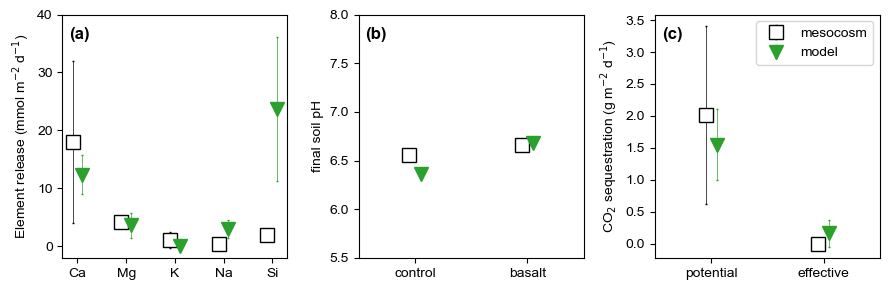

In [15]:
#figure for paper
fig, axs = plt.subplots(1, 3,figsize=(9, 3))

#------------------------------------------------------------------------------
# ELEMENT RELEASE
#------------------------------------------------------------------------------

categories = ['Ca','Mg', 'K', 'Na', 'Si']
x_pos = np.arange(len(categories))

axs[0].errorbar(x_pos-0.1, exp_avg_rel[1:], yerr=exp_err_rel[1:], marker='s', linestyle='None', 
                markersize=10, markerfacecolor='white', markeredgecolor='black', capsize=1, color='black',elinewidth=0.5)
axs[0].errorbar(x_pos+0.1, num_avg_rel[1:], yerr=num_std_rel[1:],  marker='v', linestyle='None', 
                markersize=10, markerfacecolor='tab:green', markeredgecolor='tab:green',capsize=1, color='tab:green',elinewidth=0.5)

axs[0].set_xticks(x_pos, labels=categories,fontsize=10)
axs[0].set_ylabel('Element release (mmol m$^{-2}$ d$^{-1}$)')
axs[0].set_ylim([-2,40])

#-------------------------------------------------------------------
# pH
#-------------------------------------------------------------------

categories_pH = ['control','basalt']

#experimental
pH_exp_avg = np.array([6.56, 6.66])
pH_exp_std = np.array([0.05, 0.05])
pH_end = np.array([np.mean(data_untr['pH'][int(100/dt):]),np.mean(data['pH'][int(100/dt):])])
pH_std = np.array([np.std(data_untr['pH'][int(100/dt):]),np.std(data['pH'][int(100/dt):])])

axs[1].errorbar([1-0.1, 3-0.1], pH_exp_avg, yerr=pH_exp_std, marker='s', linestyle='None', 
                markersize=10, markerfacecolor='white', markeredgecolor='black', color='black', capsize=3)
axs[1].errorbar([1+0.1, 3+0.1], pH_end, yerr=pH_std[1:],  marker='v', linestyle='None', 
                markersize=10, markerfacecolor='tab:green', markeredgecolor='tab:green',capsize=1, color='tab:green',elinewidth=0.5)

axs[1].set_ylim([5.5, 8])
axs[1].set_xlim([0, 4])
axs[1].set_xticks([1,3],labels=categories_pH)
axs[1].set_ylabel('final soil pH')

#---------------------------------------------
# CO2 sequestration
#---------------------------------------------

categories_CO2 = ['potential', 'effective']

axs[2].errorbar([1-0.1, 3-0.1], [CO2_pot_exp, CO2_eff_exp], yerr=[CO2_pot_exp_std, CO2_eff_exp_std], marker='s', linestyle='None', 
                markersize=10, markerfacecolor='white', markeredgecolor='black', color='black', capsize=1,elinewidth=0.5, label='mesocosm')
axs[2].errorbar([1+0.1, 3+0.1], [CO2_pot_num, CO2_eff_num], yerr = [CO2_pot_num_std , CO2_eff_num_std],  marker='v', linestyle='None', 
                markersize=10, markerfacecolor='tab:green', markeredgecolor='tab:green',capsize=1, color='tab:green',elinewidth=0.5,label='model')

axs[2].set_xlim([0, 4])
axs[2].set_xticks([1,3],labels=categories_CO2)
axs[2].set_ylabel('CO$_2$ sequestration (g m$^{-2}$ d$^{-1}$)', fontsize=10)
axs[2].legend(loc='best')

#panel labels
labels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(axs):
    ax.text(0.03, 0.9, labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

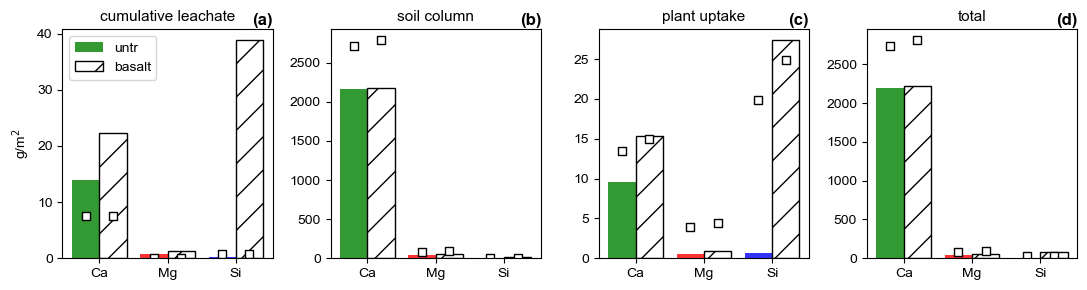

In [16]:
[MM_Mg, MM_Ca, MM_Na, MM_K, MM_Si, MM_carbon, MM_Anions,MM_Al]=pyEW.MM(conv_mol) 

# untreated elemental 
#leachate 
Ca_L_untr_num = np.trapz(data_untr['Ca']*1000*L,t)*MM_Ca #[g/m2]
Mg_L_untr_num = np.trapz(data_untr['Mg']*1000*L,t)*MM_Mg
Si_L_untr_num = np.trapz(data_untr['Si']*1000*L,t)*MM_Si
values_L_untr = np.array([Ca_L_untr_num, Mg_L_untr_num, Si_L_untr_num])
#in the column
Ca_untr_num = (data_untr['Ca_tot'][-1] + data_untr['CaCO3'][-1])*MM_Ca #[g/m2]
Mg_untr_num = (data_untr['Mg_tot'][-1] + data_untr['MgCO3'][-1])*MM_Mg 
Si_untr_num = data_untr['Si_tot'][-1]*MM_Si 
values_untr = np.array([Ca_untr_num, Mg_untr_num, Si_untr_num])
#in the plant
Ca_p_untr_num = np.trapz(data_untr['Ca']*1000*T + data_untr['UP_Ca'],t)*MM_Ca #[g/m2]
Mg_p_untr_num = np.trapz(data_untr['Mg']*1000*T + data_untr['UP_Mg'],t)*MM_Mg
Si_p_untr_num = np.trapz(data_untr['Si']*1000*T + data_untr['UP_Si'],t)*MM_Si
values_p_untr = np.array([Ca_p_untr_num, Mg_p_untr_num, Si_p_untr_num])
#total
values_tot_untr = values_L_untr+values_untr+values_p_untr

# basalt elemental
#leachate 
Ca_L_num = np.trapz(data['Ca']*1000*L,t)*MM_Ca #[mol-conv/m2]
Mg_L_num = np.trapz(data['Mg']*1000*L,t)*MM_Mg
Si_L_num = np.trapz(data['Si']*1000*L,t)*MM_Si
values_L = np.array([Ca_L_num, Mg_L_num, Si_L_num])
#in the column
Ca_num = (data['Ca_tot'][-1] + data['CaCO3'][-1])*MM_Ca #[g/m2]
Mg_num = (data['Mg_tot'][-1] + data['MgCO3'][-1])*MM_Mg 
Si_num = data['Si_tot'][-1]*MM_Si 
values = np.array([Ca_num, Mg_num, Si_num])
#in the plant
Ca_p_num = np.trapz(data['Ca']*1000*T + data['UP_Ca'],t)*MM_Ca #[g/m2]
Mg_p_num = np.trapz(data['Mg']*1000*T + data['UP_Mg'],t)*MM_Mg
Si_p_num = np.trapz(data['Si']*1000*T + data['UP_Si'],t)*MM_Si
values_p = np.array([Ca_p_num, Mg_p_num, Si_p_num])
#total
values_tot = values_L+values+values_p

#experimental
conv = 1e-3/(80**2*np.pi*1e-6) # from mg/column to g/m2
data_exp = {'element': ['Ca','Mg', 'Si'],
        #leaching
        'L_untr': [150, 1.5, 15], # [mg/column]
        'L_basalt': [150, 1.5, 15],
        #soil extraction
        'untr': [54498, 1582, 95], 
        'basalt': [56017, 1797, 117],
        #plant
        'p_untr': [270, 80, 400], 
        'p_basalt': [300, 90, 500]}
Kelland_exp = pd.DataFrame(data_exp)
numeric_columns = Kelland_exp.columns.difference(['element'])
Kelland_exp[numeric_columns] *= conv

#figure
fig, axs = plt.subplots(1,4,figsize=(11, 3))
categories = ['Ca','Mg', 'Si']
custom_colors = ['green','red', 'blue']
bar_width = 0.4
x_pos = np.arange(len(categories))

#leachate panel
axs[0].bar(x_pos, values_L_untr, width=bar_width, align='center', alpha=0.8, color=custom_colors, label = 'untr')
axs[0].bar(x_pos + bar_width, values_L, width=bar_width, align='center', hatch='/', edgecolor='black',
        fill=False, label = 'basalt')
axs[0].scatter(x_pos, Kelland_exp['L_untr'],  marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[0].scatter(x_pos + bar_width, Kelland_exp['L_basalt'],  marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[0].set_xticks(x_pos + bar_width / 2, categories)
axs[0].set_ylabel('g/m$^2$')
#axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('cumulative leachate',fontsize=11)

#column panel
axs[1].bar(x_pos, values_untr, width=bar_width, align='center', alpha=0.8, color=custom_colors)
axs[1].bar(x_pos + bar_width, values, width=bar_width, align='center', hatch='/', edgecolor='black',
        fill=False)
axs[1].scatter(x_pos, Kelland_exp['untr'],  marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[1].scatter(x_pos + bar_width, Kelland_exp['basalt'],  marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[1].set_xticks(x_pos + bar_width / 2, categories)
axs[1].set_title('soil column',fontsize=11)

#plant panel
axs[2].bar(x_pos, values_p_untr, width=bar_width, align='center', alpha=0.8, color=custom_colors)
axs[2].bar(x_pos + bar_width, values_p, width=bar_width, align='center', hatch='/', edgecolor='black',
        fill=False)
axs[2].scatter(x_pos, Kelland_exp['p_untr'],  marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[2].scatter(x_pos + bar_width, Kelland_exp['p_basalt'],  marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[2].set_xticks(x_pos + bar_width / 2, categories)
#axs[2].set_yscale('log')
axs[2].set_title('plant uptake',fontsize=11)

#total
axs[3].bar(x_pos, values_tot_untr, width=bar_width, align='center', alpha=0.8, color=custom_colors)
axs[3].bar(x_pos + bar_width, values_tot, width=bar_width, align='center', hatch='/', edgecolor='black',
        fill=False)
axs[3].scatter(x_pos, Kelland_exp['L_untr']+Kelland_exp['untr']+Kelland_exp['p_untr'],  
               marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[3].scatter(x_pos + bar_width, Kelland_exp['L_basalt']+Kelland_exp['basalt']+Kelland_exp['p_basalt'],  
               marker='s', s=30, facecolor='white', edgecolor= 'black', zorder=1)
axs[3].set_xticks(x_pos + bar_width / 2, categories)
axs[3].set_title('total', fontsize=11)

#panel labels
labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(axs):
    ax.text(0.9, 1.02, labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()